In [7]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

from utils.data_utils import load_movement_df # import data loading stuff
from utils.plot_utils import *                # import plotting stuff


path_to_data = os.path.join('..', '..', 'data')

# load scenarios for synthetic inferences
scenarios_df = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))


In [8]:

def return_scenarios_paper_sensitivity(se=0.1):
    params_truth_inferences = []

    # Scenario 0
    beta  = 0.040  # beta
    params_truth_inferences.append([{"se": se, "beta": beta}])

    # Scenario 1
    beta  = 0.035  # beta
    params_truth_inferences.append([{"se": se, "beta": beta}])

    # Scenario 2
    beta  = 0.03   # beta
    params_truth_inferences.append([{"se": se, "beta": beta}])

    # Scenario 3
    beta  = 0.025   # beta
    params_truth_inferences.append([{"se": se, "beta": beta}])

    # Scenario 4
    beta  = 0.02   # beta
    params_truth_inferences.append([{"se": se, "beta": beta}])

    # Scenario 5
    beta  = 0.015   # beta
    params_truth_inferences.append([{"se": se, "beta": beta}])

    # Scenario 6
    beta  = 0.01   # beta
    params_truth_inferences.append([{"se": se, "beta": beta}])

    # Scenario 7
    beta  = 0.005   # beta
    params_truth_inferences.append([{"se": se, "beta": beta}])

    name_scenarios  = ["scenario0", "scenario1", "scenario2", "scenario3", "scenario4", "scenario5", "scenario6", "scenario7"]
    scenarios_dicts = [{ "params_truth": params_truth_inferences[idx_this], "name": name_scenarios[idx_this]} for idx_this in range(len(name_scenarios))]

    return scenarios_dicts

def flatten_list(list_array):
    return list(itertools.chain(*list_array))



In [9]:
path_to_data = os.path.join('..', '..', 'data')
movement_df, ward2cluster = load_movement_df(path_to_data, True)

wrd_size_df = movement_df.reset_index()
wrd_size_df["num_patients"] = 1
wrd_size_df = wrd_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
wrd_size_df = wrd_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
wrd_size_df.tail( 20 )


date_min         = pd.to_datetime("2020-02-01")
date_max         = pd.to_datetime("2021-02-28")
dates_simulation = pd.date_range(start=date_min, end=date_max)


ward_size_df = movement_df.reset_index()
ward_size_df["num_patients"]= 1
ward_size_df = ward_size_df.groupby(["date", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df = ward_size_df.groupby("ward_id").mean().reset_index()
ward_id2size = {r.ward_id: r.num_patients for idx, r in ward_size_df.iterrows()}

beta_prior  = [0.001, 0.05]

abm_settings                     = {}
abm_settings["num_communities"]  = movement_df.ward_id.unique().shape[0]
abm_settings["num_patients"]     = movement_df.mrn_id.unique().shape[0]
abm_settings["num_wards"]        = movement_df.ward_id.unique().shape[0]
abm_settings["num_wards_chunks"] = len(set(list(ward2cluster.values())))
abm_settings["dates"]            = dates_simulation
abm_settings["num_ensembles"]    = 100



/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_45362/403068184.py:2: DtypeWarning: Columns (0,1,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  movement_df, ward2cluster = load_movement_df(path_to_data, True)


In [32]:
from pyro.contrib.forecast import eval_crps, eval_mae, eval_rmse
from utils.infer_utils import create_df_response
import torch


def compute_evals(samples, obs, beta, rho,  name_var="beta"):
    """_summary_

    Args:
        samples (_type_): num_ensembles x num_times
        obs (_type_): time series observation

    Returns:
        _type_: _description_
    """

    df_response          = pd.DataFrame(columns=['crps', 'mae', 'rmse', name_var, "rho"])
    df_response['crps']  = [eval_crps( samples, obs )]
    df_response['mae']   = [eval_mae(  samples, obs )]
    df_response['rmse']  = [eval_rmse( samples, obs )]
    df_response[name_var]  = [beta]
    df_response['rho']   = [rho]

    return df_response

# load staph aureus observations
def flatten_list(list_array):
    return list(itertools.chain(*list_array))

# S. aureus 15% prevalence

In [11]:


specimens_inference = ["METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",  "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS"]

test_df           = movement_df[movement_df.test==1].copy()
test_df           = test_df[test_df.organism_name.isin(specimens_inference)]
sa_df             = test_df.reset_index().groupby("date").sum()[["test"]].rename(columns={"test": "positives"}).resample("W-Sun").sum().reset_index()
sa_df = sa_df[sa_df.date.isin(dates_simulation)]
sa_df["organism"] = "Staph Aureus"

sims_df      = []
positives_df = []
metric_df = []


path_to_save          = os.path.join(results_dir, "real_testing", "community", "sensitivity")

sensitivities = [0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.11, 0.13, 0.14, 0.15]

for se  in sensitivities:
    scenarios = return_scenarios_paper_sensitivity(se)

    path_to_save_pid = os.path.join(path_to_save, "scenarios_SA", "15%", "rho_{}".format(se*100))

    for idx_scenario, scenario in enumerate(scenarios):

        scenario_params_name = scenario["name"]

        path_to_save_pid = os.path.join(path_to_save, "scenarios_SA", "15%","rho_{}".format(se*100), scenario_params_name)

        samples       = np.load(os.path.join(path_to_save_pid, 'weekly_samples.npz'))
        ward_positive = samples["ward_positive"].sum(-2)


        sim_df             = pd.DataFrame(columns=["date","ens_id", "values", "scenario"])
        sim_df["values"]   = ward_positive.flatten()
        sim_df["date"]     = flatten_list([ [date]*abm_settings["num_ensembles"]  for date in  list(abm_settings["dates"])])
        sim_df["ens_id"]   = list(range(abm_settings["num_ensembles"] )) * len(abm_settings["dates"])
        sim_df["scenario"] = "Scenario {}".format(idx_scenario+1)
        sim_df["rho"]      = se


        samples_t = sim_df.set_index(["date", "scenario", "ens_id", "rho"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
        samples_t = pd.pivot(data=samples_t, index="date", columns="ens_id", values="values").to_numpy().T
        samples_t = torch.tensor(samples_t);  obs_t  = torch.tensor(list(sa_df.positives.values))
        df_metrics = compute_evals(samples_t, obs_t, scenario["params_truth"][0]["beta"], se)
        metric_df.append(df_metrics)

        sims_df.append(sim_df)

        r_df               = create_df_response(ward_positive.T, date_init="2020-02-01", time=ward_positive.shape[0]).reset_index()
        r_df["scenario"]   = "Scenario {}".format(idx_scenario+1)
        r_df["rho"]        = se

        positives_df.append(r_df)

sims_df      = pd.concat(sims_df).set_index(["date", "scenario", "ens_id", "rho"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
positives_df = pd.concat(positives_df).set_index(["date", "scenario", "rho"]).unstack([1, 2]).resample("W-Sun").sum().stack().stack().reset_index()
metric_df    = pd.concat(metric_df)

specimens_inference = ["METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",  "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS"]

test_df           = movement_df[movement_df.test==1].copy()
test_df           = test_df[test_df.organism_name.isin(specimens_inference)]
sa_df             = test_df.reset_index().groupby("date").sum()[["test"]].rename(columns={"test": "positives"}).resample("W-Sun").sum()
sa_df["organism"] = "Staph Aureus"
sa_df             = sa_df.reset_index()
sa_df             = sa_df[sa_df.date.isin(dates_simulation)]


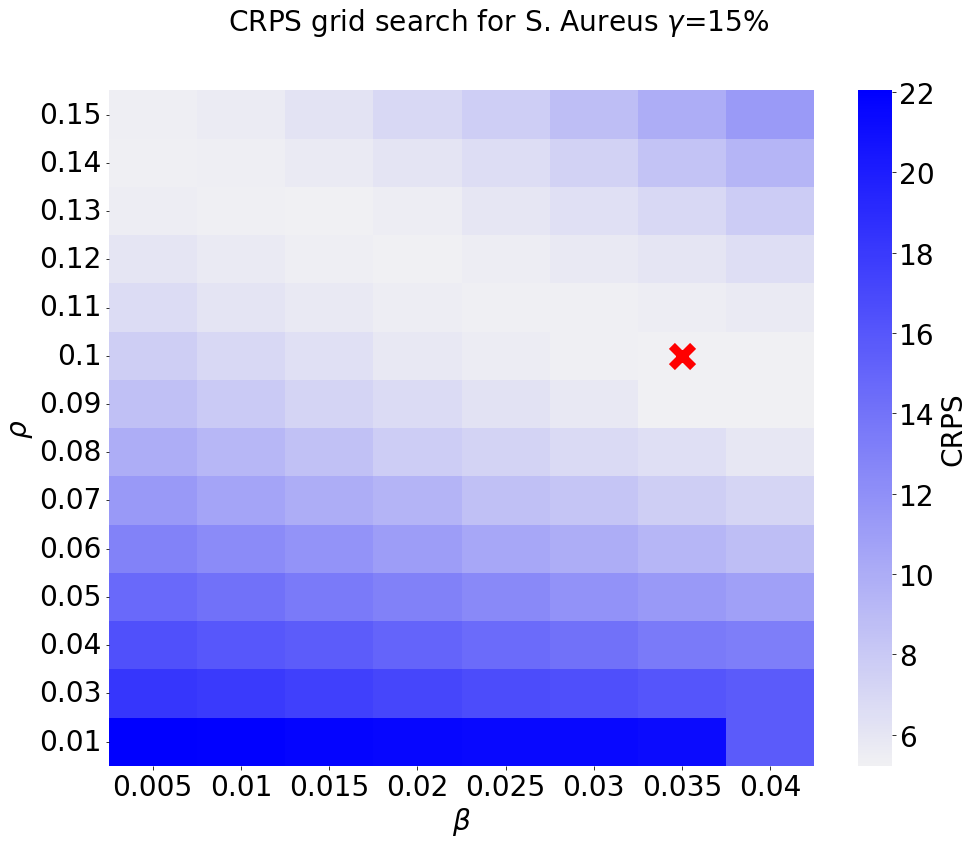

In [12]:
import seaborn as sns

metric_mat_df = pd.pivot(data=metric_df, index="rho", columns="beta", values="crps")
metric_mat_df = metric_mat_df.iloc[::-1]

fig, ax       = plt.subplots(1, 1, figsize=(14.5, 12.2))

sns.heatmap(ax=ax, data=metric_mat_df, cmap=sns.color_palette("light:b", as_cmap=True), cbar_kws={'label': "CRPS"})
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\rho$")

arg_min = np.unravel_index(np.argmin(metric_mat_df.to_numpy(), axis=None), metric_mat_df.to_numpy().shape)

beta_min  = metric_mat_df.keys()[arg_min[1]]
rho_min   = metric_mat_df.index.values[arg_min[0]]
ax.scatter(arg_min[1]+0.5, arg_min[0]+0.5, color="red", marker="x", lw=30)

fig.suptitle(r"CRPS grid search for S. Aureus $\gamma$=15%")
plt.tight_layout()

path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "GridSearchSensitivity_SA15%.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)

# S. Aureus 30% prevalence

In [13]:

specimens_inference = ["METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",  "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS"]

test_df           = movement_df[movement_df.test==1].copy()
test_df           = test_df[test_df.organism_name.isin(specimens_inference)]
sa_df             = test_df.reset_index().groupby("date").sum()[["test"]].rename(columns={"test": "positives"}).resample("W-Sun").sum().reset_index()
sa_df = sa_df[sa_df.date.isin(dates_simulation)]
sa_df["organism"] = "Staph Aureus"

sims_df      = []
positives_df = []
metric_df = []

sensitivities = [0.01, 0.05, 0.1, 0.15, 0.2]

for se  in sensitivities:
    scenarios = return_scenarios_paper_sensitivity(se)

    path_to_save_pid = os.path.join(path_to_save, "scenarios_SA", "30%", "rho_{}".format(se*100))

    for idx_scenario, scenario in enumerate(scenarios):

        scenario_params_name = scenario["name"]

        path_to_save_pid = os.path.join(path_to_save, "scenarios_SA", "30%", "rho_{}".format(se*100), scenario_params_name)

        samples       = np.load(os.path.join(path_to_save_pid, 'weekly_samples.npz'))
        ward_positive = samples["ward_positive"].sum(-2)


        sim_df             = pd.DataFrame(columns=["date","ens_id", "values", "scenario"])
        sim_df["values"]   = ward_positive.flatten()
        sim_df["date"]     = flatten_list([ [date]*abm_settings["num_ensembles"]  for date in  list(abm_settings["dates"])])
        sim_df["ens_id"]   = list(range(abm_settings["num_ensembles"] )) * len(abm_settings["dates"])
        sim_df["scenario"] = "Scenario {}".format(idx_scenario+1)
        sim_df["rho"]      = se


        samples_t = sim_df.set_index(["date", "scenario", "ens_id", "rho"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
        samples_t = pd.pivot(data=samples_t, index="date", columns="ens_id", values="values").to_numpy().T
        samples_t = torch.tensor(samples_t);  obs_t  = torch.tensor(list(sa_df.positives.values))
        df_metrics = compute_evals(samples_t, obs_t, scenario["params_truth"][0]["beta"], se)
        metric_df.append(df_metrics)

        sims_df.append(sim_df)

        r_df               = create_df_response(ward_positive.T, date_init="2020-02-01", time=ward_positive.shape[0]).reset_index()
        r_df["scenario"]   = "Scenario {}".format(idx_scenario+1)
        r_df["rho"]        = se

        positives_df.append(r_df)

sims_df      = pd.concat(sims_df).set_index(["date", "scenario", "ens_id", "rho"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
positives_df = pd.concat(positives_df).set_index(["date", "scenario", "rho"]).unstack([1, 2]).resample("W-Sun").sum().stack().stack().reset_index()
metric_df    = pd.concat(metric_df)


In [20]:

# load staph aureus observations
def flatten_list(list_array):
    return list(itertools.chain(*list_array))

specimens_inference = ["METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",  "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS"]

test_df           = movement_df[movement_df.test==1].copy()
test_df           = test_df[test_df.organism_name.isin(specimens_inference)]
sa_df             = test_df.reset_index().groupby("date").sum()[["test"]].rename(columns={"test": "positives"}).resample("W-Sun").sum().reset_index()
sa_df             = sa_df[sa_df.date.isin(dates_simulation)]
sa_df["organism"] = "Staph Aureus"

sims_df      = []
positives_df = []
metric_df    = []
sensitivities = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08]#, 0.1, 0.15, 0.2]

for se  in sensitivities:
    scenarios = return_scenarios_paper_sensitivity(se)

    for idx_scenario, scenario in enumerate(scenarios):

        scenario_params_name = scenario["name"]

        #print("Simualating scenario: {}, with rho: {}%".format(scenario_params_name.capitalize(), se*100))
        path_to_save_pid = os.path.join(path_to_save, "scenarios_SA", "30%", "rho_{}".format(se*100), scenario_params_name)
        samples       = np.load(os.path.join(path_to_save_pid, 'weekly_samples.npz'))
        ward_positive = samples["ward_positive"].sum(-2)

        sim_df             = pd.DataFrame(columns=["date","ens_id", "values", "scenario"])
        sim_df["values"]   = ward_positive.flatten()
        sim_df["date"]     = flatten_list([ [date]*abm_settings["num_ensembles"]  for date in  list(abm_settings["dates"])])
        sim_df["ens_id"]   = list(range(abm_settings["num_ensembles"] )) * len(abm_settings["dates"])
        sim_df["scenario"] = "Scenario {}".format(idx_scenario+1)
        sim_df["rho"]      = se


        samples_t = sim_df.set_index(["date", "scenario", "ens_id", "rho"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
        samples_t = pd.pivot(data=samples_t, index="date", columns="ens_id", values="values").to_numpy().T
        samples_t = torch.tensor(samples_t);  obs_t  = torch.tensor(list(sa_df.positives.values))
        df_metrics = compute_evals(samples_t, obs_t, scenario["params_truth"][0]["beta"], se)
        metric_df.append(df_metrics)

        sims_df.append(sim_df)

        r_df               = create_df_response(ward_positive.T, date_init="2020-02-01", time=ward_positive.shape[0]).reset_index()
        r_df["scenario"]   = "Scenario {}".format(idx_scenario+1)
        r_df["rho"]        = se

        positives_df.append(r_df)

sims_df      = pd.concat(sims_df).set_index(["date", "scenario", "ens_id", "rho"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
positives_df = pd.concat(positives_df).set_index(["date", "scenario", "rho"]).unstack([1, 2]).resample("W-Sun").sum().stack().stack().reset_index()
metric_df    = pd.concat(metric_df)


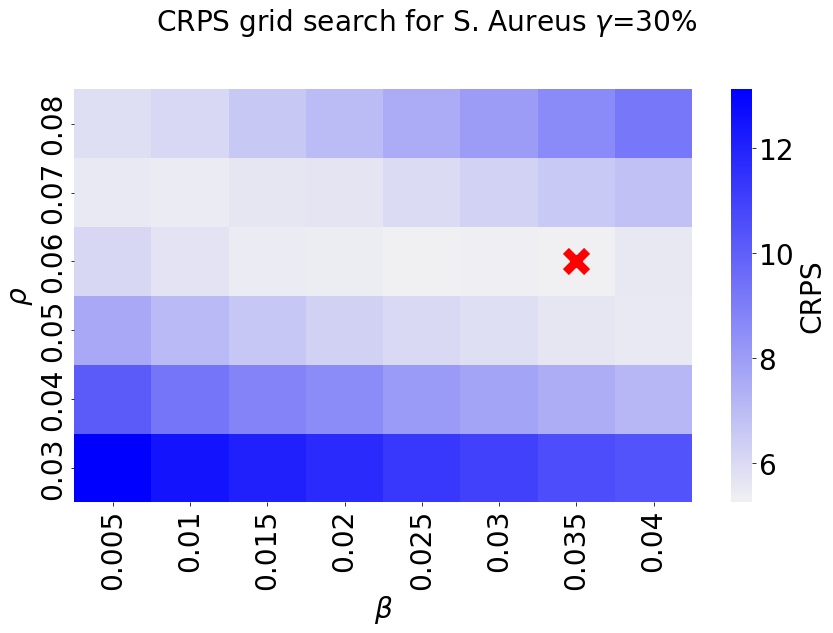

In [23]:
metric_mat_df = pd.pivot(data=metric_df, index="rho", columns="beta", values="crps")

fig, ax = plt.subplots(1, 1, figsize=(12.5, 9.2))

sns.heatmap(ax=ax, data=metric_mat_df.iloc[::-1], cmap=sns.color_palette("light:b", as_cmap=True), cbar_kws={'label': "CRPS"})
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\rho$")

arg_min = np.unravel_index(np.argmin(metric_mat_df.to_numpy(), axis=None), metric_mat_df.to_numpy().shape)

beta_min  = metric_mat_df.keys()[arg_min[1]]
rho_min   = metric_mat_df.index.values[arg_min[0]]

ax.scatter(arg_min[1]+0.5, arg_min[0]-0.5, color="red", marker="x", lw=30)

path_to_save_pid  = os.path.join(path_to_save, "scenarios_SA", "figures")
path_to_save_fig  = os.path.join(path_to_save_pid, "second_search_heatmap.png")


fig.suptitle(r"CRPS grid search for S. Aureus $\gamma$=30%")

plt.tight_layout()

path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "GridSearchSensitivity_SA30%.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)



# Relation between gamma and rho

In [33]:

def return_scenarios_paper_sensitivity(se=0.1):
    params_truth_inferences = []

    # Scenario 0
    gamma  = 0.01  # gamma
    params_truth_inferences.append([{"se": se, "gamma": gamma}])

    # Scenario 0
    gamma  = 0.05  # gamma
    params_truth_inferences.append([{"se": se, "gamma": gamma}])

    # Scenario 1
    gamma  = 0.1  # gamma
    params_truth_inferences.append([{"se": se, "gamma": gamma}])

    # Scenario 2
    gamma  = 0.15   # gamma
    params_truth_inferences.append([{"se": se, "gamma": gamma}])

    # Scenario 3
    gamma  = 0.20   # gamma
    params_truth_inferences.append([{"se": se, "gamma": gamma}])

    # Scenario 4
    gamma  = 0.25   # gamma
    params_truth_inferences.append([{"se": se, "gamma": gamma}])

    # Scenario 5
    gamma  = 0.30   # gamma
    params_truth_inferences.append([{"se": se, "gamma": gamma}])

    # Scenario 6
    gamma  = 0.35   # gamma
    params_truth_inferences.append([{"se": se, "gamma": gamma}])

    # Scenario 7
    gamma  = 0.4   # gamma
    params_truth_inferences.append([{"se": se, "gamma": gamma}])

    name_scenarios  = ["scenario0", "scenario1", "scenario2", "scenario3", "scenario4", "scenario5", "scenario6", "scenario7"]
    scenarios_dicts = [{ "params_truth": params_truth_inferences[idx_this], "name": name_scenarios[idx_this]} for idx_this in range(len(name_scenarios))]

    return scenarios_dicts


In [34]:

sims_df      = []
positives_df = []
metric_df    = []

# sensitivities = [0.05, 0.1, 0.15, 0.2]
# sensitivities = [0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.15]
# sensitivities = [0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.12, 0.11, 0.13, 0.14, 0.15]
#sensitivities = [0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.11, 0.13, 0.14, 0.15]
sensitivities = [0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.11, 0.13, 0.14, 0.15, 0.17, 0.20, 0.22, 0.25]

for se  in sensitivities:
    scenarios = return_scenarios_paper_sensitivity(se)


    for idx_scenario, scenario in enumerate(scenarios):

        scenario_params_name = scenario["name"]

        #path_to_save_pid = os.path.join(path_to_save, "scenarios_SA", "15%","rho_{}".format(se*100), scenario_params_name)

        path_to_save_pid = os.path.join(path_to_save, "scenarios_SA",  "fixed_beta_0.035", "rho_{}".format(se*100), scenario_params_name)


        path_to_samples = os.path.join(path_to_save_pid, 'weekly_samples.npz')
        if not os.path.isfile(path_to_samples):
            continue

        samples       = np.load(path_to_samples)
        ward_positive = samples["ward_positive"].sum(-2)


        sim_df             = pd.DataFrame(columns=["date","ens_id", "values", "scenario"])
        sim_df["values"]   = ward_positive.flatten()
        sim_df["date"]     = flatten_list([ [date]*abm_settings["num_ensembles"]  for date in  list(abm_settings["dates"])])
        sim_df["ens_id"]   = list(range(abm_settings["num_ensembles"] )) * len(abm_settings["dates"])
        sim_df["scenario"] = "Scenario {}".format(idx_scenario+1)
        sim_df["rho"]      = se


        samples_t  = sim_df.set_index(["date", "scenario", "ens_id", "rho"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
        samples_t  = pd.pivot(data=samples_t, index="date", columns="ens_id", values="values").to_numpy().T
        samples_t  = torch.tensor(samples_t);  obs_t  = torch.tensor(list(sa_df.positives.values))
        df_metrics = compute_evals(samples_t, obs_t, scenario["params_truth"][0]["gamma"], se, name_var="gamma")
        metric_df.append(df_metrics)

        sims_df.append(sim_df)

        r_df               = create_df_response(ward_positive.T, date_init="2020-02-01", time=ward_positive.shape[0]).reset_index()
        r_df["scenario"]   = "Scenario {}".format(idx_scenario+1)
        r_df["rho"]        = se

        positives_df.append(r_df)

sims_df      = pd.concat(sims_df).set_index(["date", "scenario", "ens_id", "rho"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
positives_df = pd.concat(positives_df).set_index(["date", "scenario", "rho"]).unstack([1, 2]).resample("W-Sun").sum().stack().stack().reset_index()
metric_df    = pd.concat(metric_df)

specimens_inference = ["METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",  "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS"]

test_df           = movement_df[movement_df.test==1].copy()
test_df           = test_df[test_df.organism_name.isin(specimens_inference)]
sa_df             = test_df.reset_index().groupby("date").sum()[["test"]].rename(columns={"test": "positives"}).resample("W-Sun").sum()
sa_df["organism"] = "Staph Aureus"
sa_df             = sa_df.reset_index()
sa_df             = sa_df[sa_df.date.isin(dates_simulation)]

In [31]:
df_metrics

,crps,mae,rmse,gamma,rho,beta
0,84.655026,90.298246,97.563028,NaN,0.25,0.35


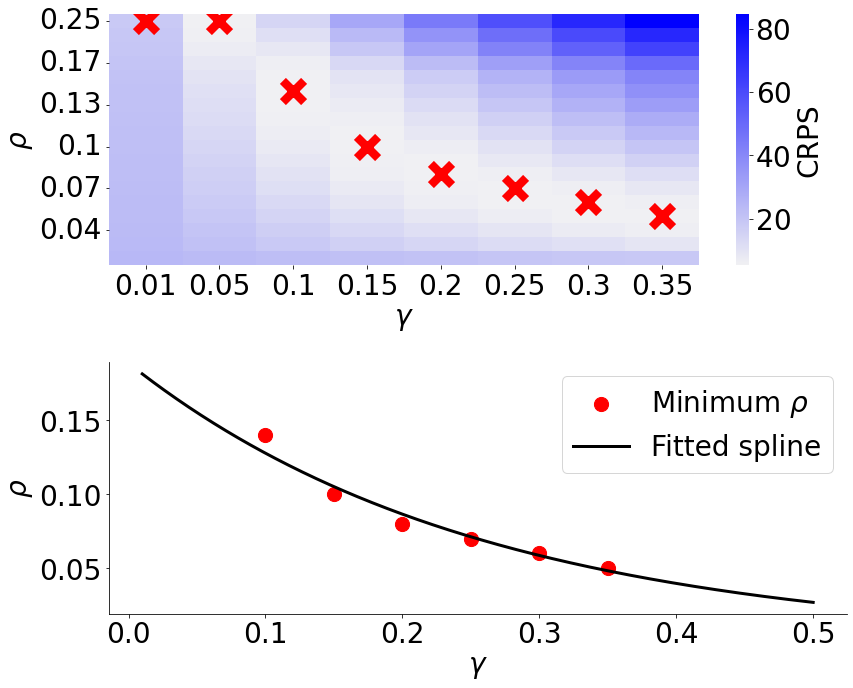

In [37]:
metric_mat_df = pd.pivot(data=metric_df, index="rho", columns="gamma", values="crps")
metric_mat_df = metric_mat_df.iloc[::-1]

fig, ax = plt.subplots(2, 1, figsize=(12.5, 10.2))

sns.heatmap(ax=ax[0], data=metric_mat_df, cmap=sns.color_palette("light:b", as_cmap=True), cbar_kws={'label': "CRPS"})
ax[0].set_xlabel(r"$\gamma$")
ax[0].set_ylabel(r"$\rho$")

arg_min = np.unravel_index(np.argmin(metric_mat_df.to_numpy(), axis=None), metric_mat_df.to_numpy().shape)

arg_rho_mins   = np.argmin(metric_mat_df.to_numpy(), axis=0)
arg_gamma_mins = np.array(list(range(metric_mat_df.shape[-1])))

ax[0].scatter(arg_gamma_mins+0.5, arg_rho_mins+0.5, color="red", marker="x", lw=30)


###

from scipy.interpolate import UnivariateSpline

def power_law(x, alpha, scale=0.1):
    return scale*x**(-alpha)

rho_mins   = metric_mat_df.index.values[arg_rho_mins]
gamma_mins = metric_mat_df.keys()[arg_gamma_mins]

# fit line to data
spl1    = UnivariateSpline(gamma_mins[2:], np.log(rho_mins[2:]), bbox=(0, 1), k=1)

gammass = np.arange(0.01, 0.5+0.001, 0.001)

ax[1].scatter(gamma_mins[2:], rho_mins[2:], s=200, fc="red", ec="red", label=r"Minimum $\rho$")
ax[1].plot(gammass, np.exp(spl1(gammass)), color="k", lw=3, label="Fitted spline")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel(r"$\gamma$")
ax[1].set_ylabel(r"$\rho$")
ax[1].legend()

plt.tight_layout()

path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "RhoGamma_Relation_.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)



In [ ]:


path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "RhoGamma_Relation.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)